In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1: Disparity

## a) Disparity equation

$$ \frac{x_1}{f} = \frac{p_x}{p_z}, \frac{-x_2}{f} = \frac{T - p_x}{p_z} $$

$$ d = x_1 - x_2 = \frac{f p_x}{p_z} + \frac{f(T - p_x)}{p_z} = \frac{fT}{p_z} $$

When the object is close, disparity is large, when it is far away, it is small.

## b) Plotting disparity

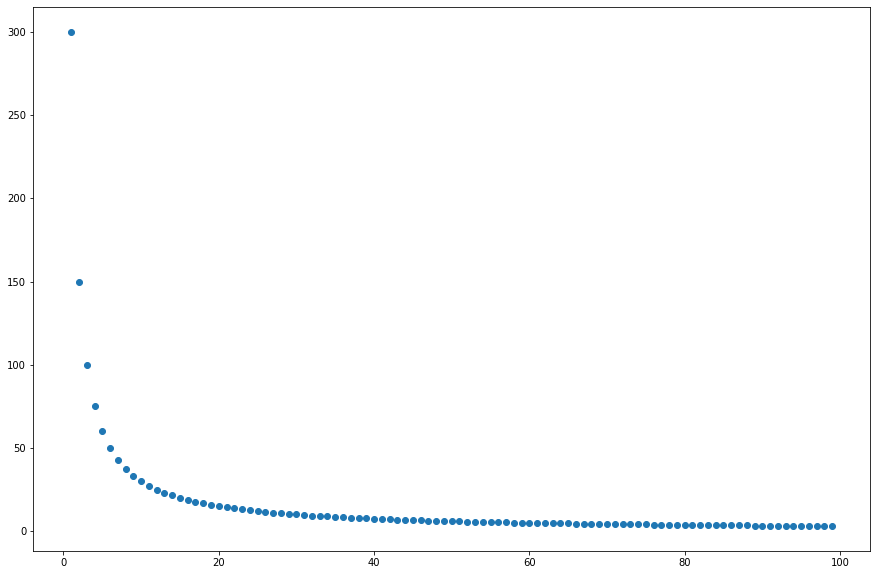

In [2]:
def disparity_example(f = 2.5, T = 120):
	pz = np.arange(1, 100)
	disp = f * T / pz
	plt.figure(figsize=(15, 10))
	plt.scatter(pz, disp)
	plt.show()

disparity_example()

## c) Specific case

$$ f = 2.5mm $$
$$ T = 120mm $$
$$ pw = 0.0074mm $$

$$ x_1 = 300 $$
$$ x_2 = 550 $$

$$ pw(x_1 - x_2) = \frac{fT}{p_z} <=> p_z = \frac{fT}{pw(x_1 - x_2)} $$

$$ p_{x_1} = \frac{2.5 * 120}{0.0074 * (550 - 300)} = 162.1mm = 0.162m $$
$$ p_{x_2} = \frac{2.5 * 120}{0.0074 * (550 - 540)} = 4054.05mm = 4.054m $$

# Exercise 2: Fundamental matrix, epipoles, epipolar lines

## Analytically

$$
x_1 = [300, 120, 1]^T \\
x_2 = [300, 170, 1]^T
$$

$$ F = \begin{bmatrix} 
0 & 0 & 0.002 \\
0 & 0 & −0.012 \\
−0.001 & 0.011 & −0.085
\end{bmatrix} \\ $$


$$ Fx_1 = [\frac{1}{500}, \frac{-3}{250}, \frac{187}{200}]^T $$
$$ Fx_2 = [\frac{1}{500}, \frac{-3}{250}, \frac{297}{200}]^T $$

## a) Function fundamental_matrix

In [3]:
from a5_utils import normalize_points, draw_epiline

In [4]:
def fundamental_matrix(points1, points2):
	pnorm1, T1 = normalize_points(points1)
	pnorm2, T2 = normalize_points(points2)
	A = []
	for p1, p2 in zip(pnorm1, pnorm2):
		A.append([p1[0] * p2[0], p1[0] * p2[1], p1[0], p1[1] * p2[0], p1[1] * p2[1], p1[1], p2[0], p2[1], 1])
	
	_, _, V = np.linalg.svd(A)
	Ft = V.T[:,-1].reshape(3,3)
	Uf, Df, Vf = np.linalg.svd(Ft)
	Df[-1] = 0
	F = (Uf * Df) @ Vf
	F = T2.T @ F.T @ T1
	return F

## b) Testing the function

In [5]:
house_points = np.array(open('data/epipolar/house_points.txt', 'r').read().split()).reshape(-1,4).astype(np.float64)
house_points_1 = house_points[:,0:2]
house_points_2 = house_points[:,2:4]
house_points_F = fundamental_matrix(house_points_1, house_points_2)
print(house_points_F)

[[-8.85211824e-07 -5.61591880e-06  1.94310952e-03]
 [ 9.39281870e-06  6.16883199e-07 -1.20066302e-02]
 [-1.20308414e-03  1.10370070e-02 -8.53173359e-02]]


In [6]:
house1 = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2GRAY)
house2 = cv2.cvtColor(cv2.imread('data/epipolar/house2.jpg'), cv2.COLOR_BGR2GRAY)

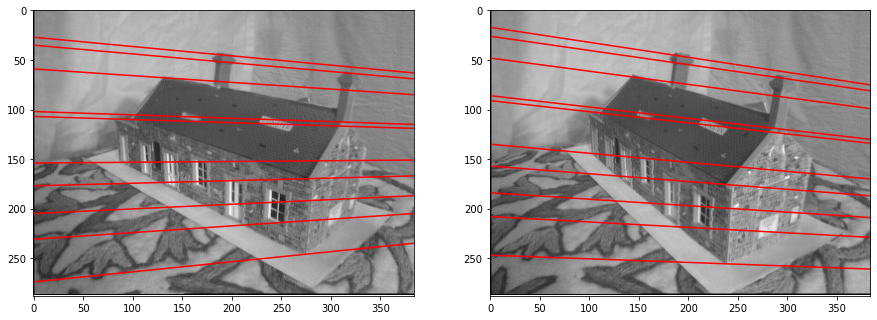

In [54]:
plt.figure(figsize=(15, 10))
plt.subplot(1,2,1), plt.imshow(house1, cmap='gray')
h, w = house1.shape
for px, py in house_points_2:
	e = np.array([px, py, 1])
	l = house_points_F.T @ e
	draw_epiline(l, h, w)

plt.subplot(1,2,2), plt.imshow(house2, cmap='gray')
h, w = house2.shape
for px, py in house_points_1:
	e = np.array([px, py, 1])
	l = house_points_F @ e
	draw_epiline(l, h, w)
plt.show()

## c) Reprojection error

In [8]:
def reprojection_error(x1, x2, F):
	px1 = np.array([x1[0], x1[1], 1])
	px2 = np.array([x2[0], x2[1], 1])
	line1 = F.T @ px2
	line2 = F @ px1
	d1 = np.abs((line1[0] * px1[0] + line1[1] * px1[1] + line1[2]) / np.sqrt(line1[0] ** 2 + line1[1] ** 2))
	d2 = np.abs((line2[0] * px2[0] + line2[1] * px2[1] + line2[2]) / np.sqrt(line2[0] ** 2 + line2[1] ** 2))

	return (d1 + d2) / 2

In [9]:
reprojection_error([85, 233], [67, 219], house_points_F)

0.1467436557046618

In [10]:
error = 0
counter = 0
for x1, x2 in zip(house_points_1, house_points_2):
	err = reprojection_error(x1, x2, house_points_F)
	error += err
	counter += 1

print(error / counter)

0.33091336980539376


## d) Ransac: get_inliers

In [11]:
def get_inliers(F, corr, threshold):
	x_pts  = corr[:,0:2]
	xi_pts = corr[:,2:4]

	points = []
	for x, xi in zip(x_pts, xi_pts):
		dist = reprojection_error(x, xi, F)
		if dist < threshold:
			points.append(np.hstack([x, xi]))
	return np.array(points)

## e) Ransac: ransac_fundamental

In [12]:
def ransac_fundamental(in_points, k, threshold):
	max_inliers = np.array([])
	max_F = 0
	for i in range(k):
		points = in_points[np.random.choice(range(len(in_points)), 8, replace=False)]
		points_1 = points[:,0:2]
		points_2 = points[:,2:4]
		F_mat = fundamental_matrix(points_1, points_2)
		inliers = get_inliers(F_mat, points, threshold)
		if inliers.shape[0] >= max_inliers.shape[0]:
			max_inliers = inliers
			inl1 = inliers[:,0:2]
			inl2 = inliers[:,2:4]
			max_F = fundamental_matrix(inl1, inl2)
	return max_F

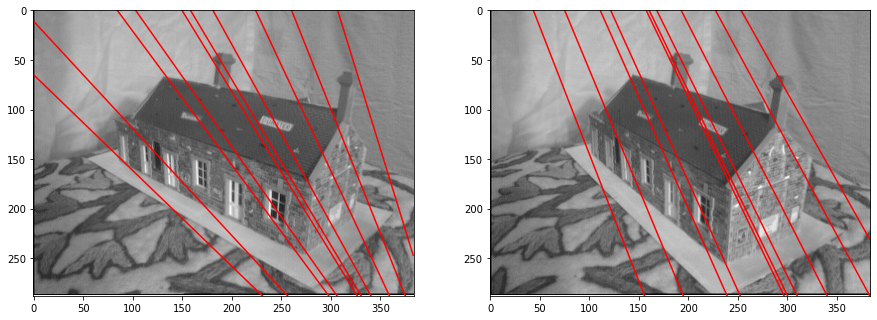

In [65]:
house_matches = np.array(open('data/epipolar/house_matches.txt', 'r').read().split()).reshape(-1,4).astype(np.float64)
house_matches_1 = house_matches[:,0:2]
house_matches_2 = house_matches[:,2:4]

ransac_F = ransac_fundamental(house_matches, 100, 2)

plt.figure(figsize=(15, 10))
plt.subplot(1,2,1), plt.imshow(house1, cmap='gray')
h, w = house1.shape
for px, py in house_points_2:
	e = np.array([px, py, 1])
	l = ransac_F.T @ e
	draw_epiline(l, h, w)

plt.subplot(1,2,2), plt.imshow(house2, cmap='gray')
h, w = house2.shape
for px, py in house_points_1:
	e = np.array([px, py, 1])
	l = ransac_F @ e
	draw_epiline(l, h, w)
plt.show()

## f) Ransac: Automatic fundamental matrix estimation

In [21]:
def gauss(sigma, size = -1, rng = False):
	if size == -1:
		size = 6 * sigma + 1
	kern = np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	kern = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(kern ** 2) / (2 * (sigma ** 2)))
	kern /= np.sum(kern)

	if rng == True:
		return kern, np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	else:
		return kern

def gaussdx(sigma, size = -1, rng = False):
	if size == -1:
		size = 6 * sigma + 1
	kern = np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	kern = -(1 / (np.sqrt(2 * np.pi) * sigma ** 3)) * kern * np.exp(-(kern ** 2) / (2 * (sigma ** 2)))
	kern /= np.sum(np.abs(kern))

	if rng == True:
		return kern, np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	else:
		return kern

def partial_derivatives(img, sigma):
	gkern = np.array([gauss(sigma)])
	dkern = np.array([gaussdx(sigma)])

	Ix = np.copy(img).astype(np.float32)
	Iy = np.copy(img).astype(np.float32)
	
	Ix = cv2.filter2D(Ix, -1, gkern)
	Ix = cv2.filter2D(Ix, -1, np.fliplr(dkern))
	Iy = cv2.filter2D(Iy, -1, gkern.T)
	Iy = cv2.filter2D(Iy, -1, np.flipud(dkern.T))

	Ixx = np.copy(Ix).astype(np.float32)
	Ixy = np.copy(Ix).astype(np.float32)
	Iyy = np.copy(Iy).astype(np.float32)

	Ixx = cv2.filter2D(Ixx, -1, gkern)
	Ixx = cv2.filter2D(Ixx, -1, np.fliplr(dkern))
	Ixy = cv2.filter2D(Ixy, -1, gkern.T)
	Ixy = cv2.filter2D(Ixy, -1, np.flipud(dkern.T))
	Iyy = cv2.filter2D(Iyy, -1, gkern.T)
	Iyy = cv2.filter2D(Iyy, -1, np.flipud(dkern.T))

	return Ix, Iy, Ixx, Ixy, Iyy

def nms(himg):
	img = np.pad(np.copy(himg), 1)
	pimg = np.copy(img)
	h, w = pimg.shape

	for y in range(1, h-1):
		for x in range(1, w-1):
			sect = np.delete(pimg[y-1:y+2,x-1:x+2], 4)
			if img[y,x] <= np.max(sect):
				img[y,x] = 0

	return img[1:-1,1:-1]

def convolve(img, kernel):
	img = np.copy(img)
	img = cv2.filter2D(img, -1, kernel)
	img = cv2.filter2D(img, -1, kernel.T)
	return img

def harris_feature_detection(img, sigma, threshold):
	Ix, Iy, _, Ixy, _ = partial_derivatives(img, sigma)
	gkern = np.array([gauss(1.6 * sigma)])
	alpha = 0.06

	cix = convolve(Ix ** 2, gkern) * sigma ** 2
	ciy = convolve(Iy ** 2, gkern) * sigma ** 2
	cixy = convolve(Ix * Iy, gkern) * sigma ** 2

	h_det = cix * ciy - cixy ** 2
	h_trace = cix + ciy
	res = h_det - alpha * h_trace ** 2

	return res, np.argwhere(nms(res) > threshold)

def simple_descriptors(I, pts, bins=16, radius=40, sigma=1):
	g = np.array([gauss(sigma)])
	d = np.array([gaussdx(sigma)])

	Ix = cv2.filter2D(I, cv2.CV_32F, g.T)
	Ix = cv2.filter2D(Ix, cv2.CV_32F, d)
	Iy = cv2.filter2D(I, cv2.CV_32F, g)
	Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

	Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
	Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)
	Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
	Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)

	mag = np.sqrt(Ix**2+Iy**2)
	mag = np.floor(mag*((bins-1)/np.max(mag)))

	feat = Ixx+Iyy
	feat += abs(np.min(feat))
	feat = np.floor(feat*((bins-1)/np.max(feat)))

	desc = []

	for y,x in pts:
		minx = max(x-radius, 0)
		maxx = min(x+radius, I.shape[0])
		miny = max(y-radius, 0)
		maxy = min(y+radius, I.shape[1])
		r1 = mag[minx:maxx, miny:maxy].reshape(-1)
		r2 = feat[minx:maxx, miny:maxy].reshape(-1)
	
		a = np.zeros((bins,bins))
		for m, l in zip(r1,r2):
			a[int(m),int(l)]+=1

		a=a.reshape(-1)
		summm = np.sum(a)
		if summm > 0:
			a /= summm

		desc.append(a)

	return np.array(desc)

def find_correspondances(list1, list2):
	comp = []
	for i in range(len(list1)):
		res = np.sqrt(0.5 * np.sum((np.sqrt(list1[i]) - np.sqrt(list2[:])) ** 2, axis=1))
		comp.append(np.argwhere(res == np.min(res))[0])

	return np.array(comp)

def find_correspondances_s(list1, list2):
	c1 = find_correspondances(list1, list2)[:,0]
	c2 = find_correspondances(list2, list1)[:,0]

	indexes = np.arange(len(c1))
	argw = indexes[indexes == c2[c1]]
	return np.array(list(zip(argw, c1[argw])))

def find_matches(img1, img2, sigma = 6, threshold = 100):
	_, img1_keypt = harris_feature_detection(img1, sigma, threshold)
	_, img2_keypt = harris_feature_detection(img2, sigma, threshold)
	img1_keypt_r = np.stack((img1_keypt[:,1],img1_keypt[:,0]), axis=1)
	img2_keypt_r = np.stack((img2_keypt[:,1],img2_keypt[:,0]), axis=1)

	img1_desc = simple_descriptors(img1, img1_keypt_r)
	img2_desc = simple_descriptors(img2, img2_keypt_r)

	return img1_keypt, img2_keypt, find_correspondances_s(img1_desc, img2_desc)